### **The code below is for the classification of Data Set 2 from BCI Competition 3.**

*See a more detailed description [here](http://www.bbci.de/competition/iii/desc_II.pdf)*

The only difference is that instead of classifying what character it is that the user is focusing attention to, I have choosen to classify the row in which the desired character is in to reduce the number of available classes to choose from, and thereby reducing the complexity. 

For example, if originally, the correct answer was the letter 'H', the correct answers is now 2 for row 2. 

**Row 1** -----> A B C D E F
 
**Row 2** -----> G H I J K L
 
**Row 3** -----> M N O P Q R
 
**Row 4** -----> S T U V W X 
 
**Row 5** -----> Y Z 1 2 3 4 
 
**Row 6** -----> 5 6 7 8 9 _



Importing the neccessary libraries below.

In [1]:
from __future__ import division
import pandas
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib

import wyrm
from wyrm import plot
from wyrm.types import Data
from wyrm import processing as proc
from wyrm.io import load_bcicomp3_ds2
plot.beautify()

Defining the testing and training labels for Subject A.    

For training: **85** labels corresponding to **85** training sets.
For testing: **100** labels corresponding to **100** testing sets.

In [2]:
TRAIN_A = '/Users/shreya/Documents/workspace/BCI3Data2/data/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
TEST_A = '/Users/shreya/Documents/workspace/BCI3Data2/data/BCI_Comp_III_Wads_2004/Subject_A_Test.mat'

TRAINING_LABELS_A = "1114341322631123311121442113423136344311342415421135332253314612421441334225135334232"
TESTING_LABELS_A = '4343251333236651511551326334233121443314333215415333626212512316423121443354132241161111141462535334'

In [3]:
import logging
logging.getLogger('tensorflow').disabled = True

Used the preprocessing method as written here -->
https://github.com/venthur/wyrm/blob/master/examples/BCI%20Competition%203%2C%20Data%20Set%202%20(P300%20Speller).ipynb

In [4]:
MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

MARKER_DEF_TRAIN = {'target': ['target'], 'nontarget': ['nontarget']}
MARKER_DEF_TEST = {'flashing': ['flashing']}

SEG_IVAL = [0, 700]
JUMPING_MEANS_IVALS_A = [150, 220], [200, 260], [310, 360], [550, 660] # 91%

Code below is mostly from the *preprocessing_simple* method from the link above. Added my own normalization code within the *preprocessing_simple* method.

In [5]:
def preprocessing_simple(dat, epochsTotal, MRK_DEF, *args, **kwargs):    
    
    totalChannels = 64
    totalEpochs = epochsTotal # epochsTotal will vary based on whether this is the training or testing dataset
    samplesPerEpoch = 7560 # every epoch has 7794 samples, but  samples 7560 - 7794 are extra recordings after the 180 intensifications
    
    
    datSignal = np.transpose(dat.data)
    dim = 64*totalEpochs
    datSignal = datSignal.reshape(dim, 7794)
    datSignal = datSignal.reshape(64, epochsTotal, 7794)
    
    
    #dat.fs is the sampling frequency of the data in Hz 
    #nyquist frequency is half the sampling rate
    
    numberOfSamples = samplesPerEpoch*totalEpochs # number of samples per channel 
    totalTime = numberOfSamples/240 #due to the 240 Hz sampling frequency
    plotTime = np.linspace(0, totalTime, numberOfSamples)

# ---------------------------------------------------------------------------------------
    # Graphs for what channel 1's data and channel 63's data looked like before normalization as an example. 

    channel1Data = datSignal[0,:,0:7560] 
    c1Data = channel1Data.flatten()
    
    channel63Data = datSignal[63,:,0:7560]
    c63Data = channel63Data.flatten()
    %matplotlib inline

    plt.figure(figsize=(12,15))

    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(2, 1)
    plt.subplot(gs[0, 0])
    plt.plot(plotTime,c1Data,'r.') # have to share at least one dimension (both have been flattened 180*14)
    plt.title('Channel 1, All Epochs')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (uV)')
    plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images2.png')


    
    plt.subplot(gs[1,0])
    plt.plot(plotTime,c63Data,'g.') # have to share at least one dimension (both have been flattened 180*14)
    plt.title('Channel 2, All Epochs')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (uV)')
    
    plt.show()

# ---------------------------------------------------------------------------------------
# Below is the normalization of the data 

    print "Normalization begins."
    
    from scipy import stats
    counterA = 0
    
    for j in range(64):
                            
        for k in range(totalEpochs): # for all epochs across one channel
            
            idxInt = 0;  # index of every intensification
            
            for i in range(180):
                # every epoch has 7794 samples ( 24 active + 18 rest, 24 active ...)
                
                counterA=counterA+1
                mean = 0
                std = 0
                a = 0
                b = 0
                
                # separate each intensification
                # index using idxInt:idxInt+42 because every intensification contains 42 samples
                intensification = datSignal[j, k, idxInt:idxInt+42]
                
                # find the z-score for every intensification
                intensification = stats.zscore(intensification)

                datSignal[j, k, idxInt:idxInt+42] = intensification 

                idxInt += 42 # every interval is 24 + 18 (active + rest)
                            
            datSignal[j, k, 7560:] = np.zeros(234)
# ---------------------------------------------------------------------------------------
# Below are the graphs for the normalized data for channel 1 and channel 63 as an example. 

    normalizedData1 = datSignal[0,:,0:7560]
    flatND1 = normalizedData1.flatten()
    
    normalizedData63 = datSignal[63,:,0:7560]
    flatND63 = normalizedData63.flatten()
    
    %matplotlib inline

    plt.figure(figsize=(12,15))
    gs2 = gridspec.GridSpec(2, 1)
    plt.subplot(gs2[0, 0])
    plt.plot(plotTime,flatND1,'r.') # have to share at least one dimension (both have been flattened 180*14)
    plt.title('Normalized Channel 1, All Epochs')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (uV)')
    plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images2.png')


    plt.subplot(gs2[1, 0])
    plt.plot(plotTime,flatND63,'g.') # have to share at least one dimension (both have been flattened 180*14)
    plt.title('Normalized Channel 63, All Epochs')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (uV)')
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
# ---------------------------------------------------------------------------------------
# Checking the mean and standard deviation of the intensifications after normalization.
# When using z-scores, the standard deviation should be (if not, very close to) 1 
# and the mean should be (if not, very close to) 0.

    print ("After Normalization")
    print ("First intensification", datSignal[0,15,0:42])
    print ("mean", np.mean(datSignal[0,15,0:42]))
    print ("standard deviation", np.std(datSignal[0,15,0:42]))
    print ("Second intensification", datSignal[0,35,42:84])
    print ("mean", np.mean(datSignal[0,35,42:84]))
    print ("standard deviation", np.std(datSignal[0,35,42:84]))
    
    datSignal = datSignal.reshape(dim, 7794)
    

# ---------------------------------------------------------------------------------------
# using same code from wyrm's io.py but replacing data parameter of data object with normalized data (datSignal)
    from wyrm.types import Data
    from scipy.io import loadmat
    from os import path

    dim2 = 7794*totalEpochs
    datSignal = datSignal.reshape(64, dim2) 

    
    datSignal = np.transpose(datSignal)
    
    if epochsTotal == 85:
        filename = TRAIN_A
    else:
        filename = TEST_A
    
    STIMULUS_CODE = {
        # cols from left to right
        1 : "agmsy5",
        2 : "bhntz6",
        3 : "ciou17",
        4 : "djpv28",
        5 : "ekqw39",
        6 : "flrx4_",
        # rows from top to bottom
        7 : "abcdef",
        8 : "ghijkl",
        9 : "mnopqr",
        10: "stuvwx",
        11: "yz1234",
        12: "56789_"
    }

    data_mat = loadmat(filename)
        
    eloc_file = path.sep.join([path.dirname(filename), 'eloc64.txt'])
    with open(eloc_file) as fh:
        data = fh.read()
    channels = []
    for line in data.splitlines():
        if line:
            chan = line.split()[-1]
            chan = chan.replace('.', '')
            channels.append(chan)
            
    for i, s in enumerate(channels):
        s2 = s.upper()
        s2 = s2.replace('Z', 'z')
        s2 = s2.replace('FP', 'Fp')
        channels[i] = s2

    flashing = data_mat['Flashing'].reshape(-1)
    tmp = []
    for i, _ in enumerate(flashing):
        if i == 0:
            tmp.append(flashing[i])
            continue
        if flashing[i] == flashing[i-1] == 1:
            tmp.append(0)
            continue
        tmp.append(flashing[i])
        
    flashing = np.array(tmp)
    stimulus_code = data_mat['StimulusCode'].reshape(-1)
    stimulus_code = stimulus_code[flashing == 1]
    stimulus_type = data_mat.get('StimulusType', np.array([])).reshape(-1)
    target_chars = data_mat.get('TargetChar', np.array([])).reshape(-1)

    fs = 240
    timeaxis = np.linspace(0, datSignal.shape[0] / fs * 1000, datSignal.shape[0], endpoint=False)


    datNew = Data(data=datSignal, axes=[timeaxis, channels], names=dat.names, units=dat.units)

    datNew.fs = fs
    
    # preparing the markers
    target_mask = np.logical_and((flashing == 1), (stimulus_type == 1)) if len(stimulus_type) > 0 else []
    nontarget_mask = np.logical_and((flashing == 1), (stimulus_type == 0)) if len(stimulus_type) > 0 else []
    flashing = (flashing == 1)
    flashing = [[i, 'flashing'] for i in timeaxis[flashing]]
    targets = [[i, 'target'] for i in timeaxis[target_mask]]
    nontargets = [[i, 'nontarget'] for i in timeaxis[nontarget_mask]]
    datNew.stimulus_code = stimulus_code[:]
    stimulus_code = zip([t for t, _ in flashing], [STIMULUS_CODE[i] for i in stimulus_code])
    markers = flashing[:]
    markers.extend(targets)
    markers.extend(nontargets)
    markers.extend(stimulus_code)
    markers.sort()
    datNew.markers = markers[:]
    
    print datNew.data.shape

# ---------------------------------------------------------------------------------------

    fs_n = dat.fs / 2
        
    #btype is band type | band type is low pass
    #10 is desired low frequency in Hz
    b, a = proc.signal.butter(5, [10 / fs_n], btype='low')
    
    #filtfilt does a forward filter and a backward filter
    #the numerator coefficient vector
    #the denominator coefficient vector
    datNew = proc.filtfilt(datNew, b, a)
    print datNew.data.shape
    
    datNew = proc.subsample(datNew, 20)
    print datNew.data.shape
    
    epo = proc.segment_dat(datNew, MRK_DEF, SEG_IVAL)
    print epo.data.shape
    
    print ""
    print "epo dimension ", epo.data.shape
    fv = proc.create_feature_vectors(epo)
    print fv.data.shape
    print "feature vector dimensions ", fv.data.shape
    print ""
    
    x = fv.data
    
    print "The frequency vector has ", x.shape[0], " rows."
    
    #896 [14 samples * 64 channels / 14= 20-6 because 6 samples lost in subsampling)]
    print "The frequency vector has ", x.shape[1], " columns. (values per row)"
        
    return fv, epo

#### Separating the true labels into separate characters.

In [6]:
import numpy.random as r
def convert_string_to_char_vector(labels):
    vector = np.chararray(len(labels))
    for i in range(len(labels)):
        vector[i] = labels[i]
    return vector

#### Importing more needed libraries.

In [7]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [8]:
epo = [None, None]
acc = 0
training_set = TRAIN_A
testing_set = TEST_A
labels = TESTING_LABELS_A
jumping_means_ivals = JUMPING_MEANS_IVALS_A

#### Loading the training dataset and calling the *preprocessing_simple* function. This function *normalizes* and *preprocesses* the data.

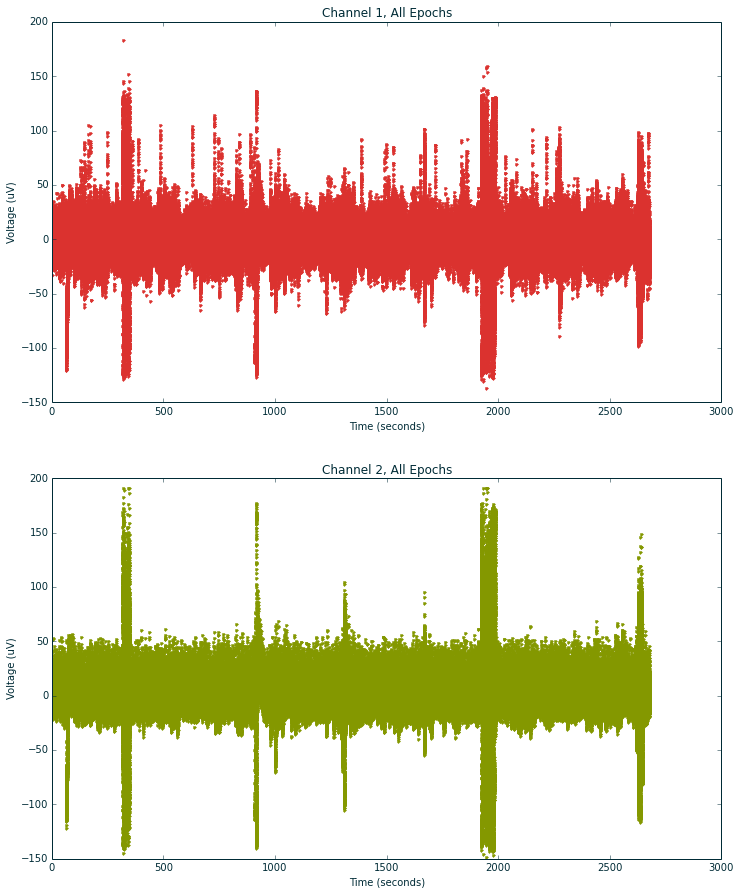

Normalization begins.


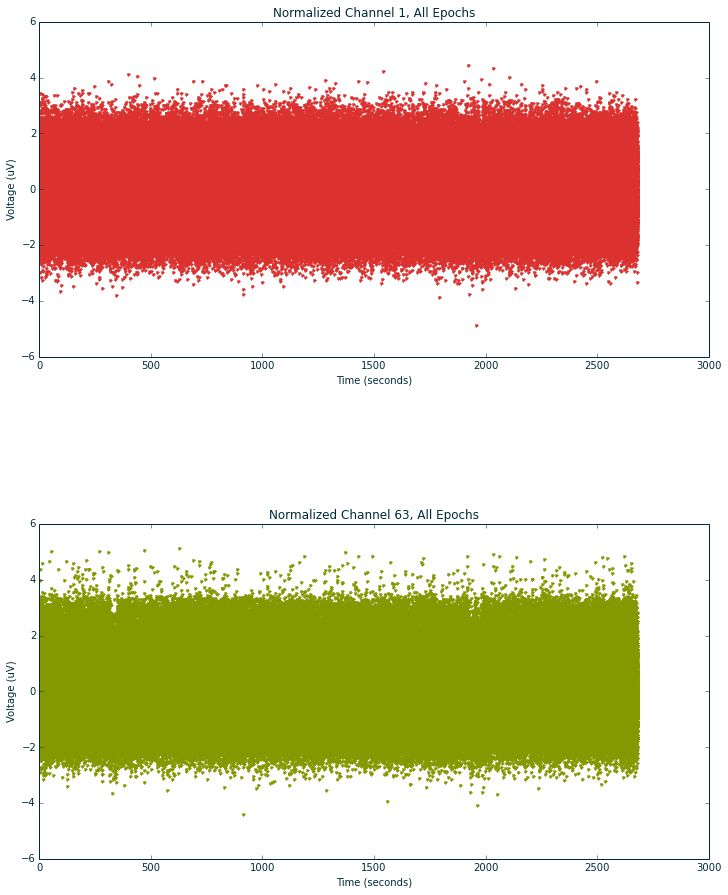

After Normalization
('First intensification', array([-0.77308587, -1.1664735 , -0.65204352,  0.25577398,  0.43733747,
        0.67942215,  0.52811922,  0.10447106, -0.01657127,  0.34655572,
        0.52811922,  1.82932431,  2.31349362,  0.52811922, -0.59152237,
        0.13473165,  0.7399433 ,  1.01228852,  0.8004645 ,  1.04254915,
        1.34515501,  0.77020393, -0.80334644, -1.19673402, -0.01657127,
        0.37681632,  0.01368931,  0.01368931,  0.31629515,  0.07421048,
       -0.04683185,  0.07421048,  0.22551339, -1.22699465, -2.28611504,
       -1.95324855,  0.46759807,  0.83072508, -1.04543109, -2.25585441,
       -1.7716851 ,  0.01368931]))
('mean', 1.6521175961683876e-19)
('standard deviation', 0.9999999999999999)
('Second intensification', array([ 2.13123381,  2.13123381,  2.37250564, -0.24127159, -1.84975007,
        1.36720659,  2.33229362, -0.04021208, -0.76402728, -0.16084785,
        0.76402716,  1.84975026,  1.16614678,  0.12063601, -0.40211968,
       -0.36190766, -0.1

(662490, 64)
(55208, 64)
(15300, 14, 64)

epo dimension  (15300, 14, 64)
(15300, 896)
feature vector dimensions  (15300, 896)

The frequency vector has  15300  rows.
The frequency vector has  896  columns. (values per row)


In [9]:
dat = load_bcicomp3_ds2(training_set)
fv_train, epo[0] = preprocessing_simple(dat, 85, MARKER_DEF_TRAIN, jumping_means_ivals)

In [10]:
myCustomAlphabet = "123456"

Below is the function for **one-hot-encoding** of the output. 

In [11]:
def onehotencode(charLabels, alphabet):
    dimension = len(charLabels)
    encodedMatrix = np.zeros(6*dimension).reshape(dimension, 6)
    
    for j in range(encodedMatrix.shape[0]):
        for k in range(encodedMatrix.shape[1]):
            if charLabels[j] == alphabet[k]:
                encodedMatrix[j][k] = 1
    
    return encodedMatrix

#### Starting one hot encoding for the training labels.

First split labels into **separate characters**.

In [12]:
separateLabels = convert_string_to_char_vector(TRAINING_LABELS_A)
print (separateLabels)

['1' '1' '1' '4' '3' '4' '1' '3' '2' '2' '6' '3' '1' '1' '2' '3' '3' '1'
 '1' '1' '2' '1' '4' '4' '2' '1' '1' '3' '4' '2' '3' '1' '3' '6' '3' '4'
 '4' '3' '1' '1' '3' '4' '2' '4' '1' '5' '4' '2' '1' '1' '3' '5' '3' '3'
 '2' '2' '5' '3' '3' '1' '4' '6' '1' '2' '4' '2' '1' '4' '4' '1' '3' '3'
 '4' '2' '2' '5' '1' '3' '5' '3' '3' '4' '2' '3' '2']


#### Below is how the label looks after it is one hot encoded

In [13]:
encoded_labels = onehotencode(separateLabels, myCustomAlphabet)

print ("Sample labels and encoding")
print (separateLabels[0], encoded_labels[0])
print (separateLabels[1], encoded_labels[1])
print (separateLabels[3], encoded_labels[3])
print (separateLabels[14], encoded_labels[14])
print (separateLabels[22], encoded_labels[22])

y_train = encoded_labels

Sample labels and encoding
('1', array([1., 0., 0., 0., 0., 0.]))
('1', array([1., 0., 0., 0., 0., 0.]))
('4', array([0., 0., 0., 1., 0., 0.]))
('2', array([0., 1., 0., 0., 0., 0.]))
('4', array([0., 0., 0., 1., 0., 0.]))


#### Reshaping the training data to feed as input to the neural network. 

New dimensions:

**85** - for every sample (training set has 85 samples).

**64** - for every electrode/channel.

**2520** - total time series of every epoch (14 samples for 180 intensifications)

In [14]:
yNew = fv_train.data.reshape(15300, 14, 64)
z = np.transpose(yNew)
x_trainTemp = z.reshape(64, 214200)
print ("Original dimensions")
print (x_trainTemp.shape)

x_trainTemp2 = x_trainTemp.reshape(64, 85, 2520)
print ("Temporary dimensions")
print (x_trainTemp2.shape)

x_train = np.zeros(13708800).reshape(85, 64, 2520)
for i in range(85):
    x_train[i] = x_trainTemp2[:, i, :]
    
print ("Final dimensions")
print (x_train.shape)

Original dimensions
(64, 214200)
Temporary dimensions
(64, 85, 2520)
Final dimensions
(85, 64, 2520)


#### Loading the testing dataset and calling the *preprocessing_simple* function. This function *normalizes* and *preprocesses* the data.

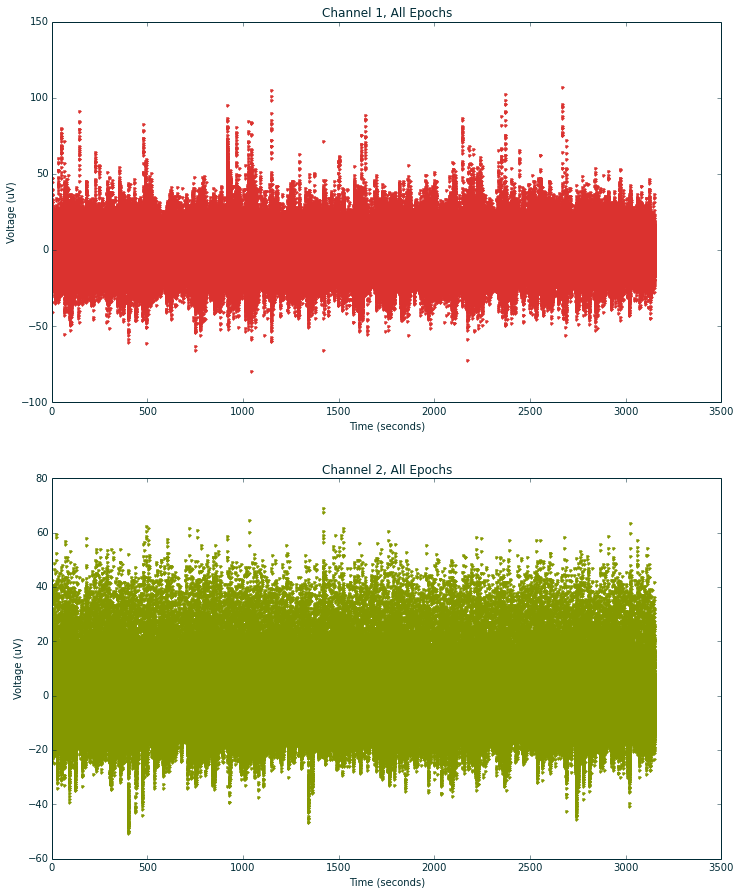

Normalization begins.


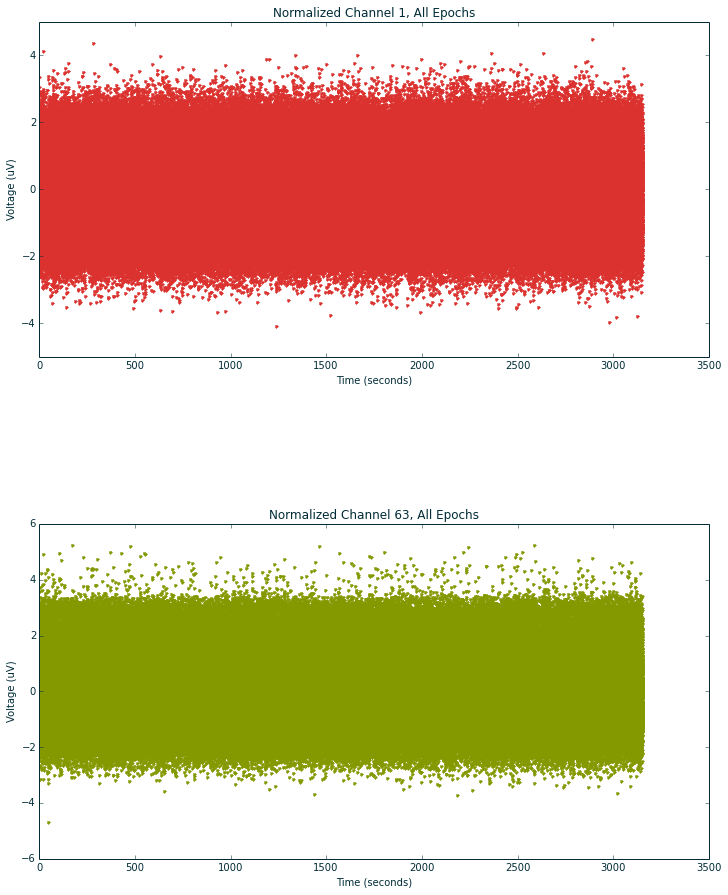

After Normalization
('First intensification', array([ 1.27149043,  1.14583729,  0.580398  ,  0.93641533,  0.55945581,
        0.09872749,  0.74793555,  1.56468115,  1.25054828,  0.30814944,
        0.64322456,  0.83170434,  1.18772167,  0.55945581,  0.18249627,
        0.81076215, -0.42482739, -1.11591982, -0.48765399,  0.11966969,
       -1.13686205, -2.05831867, -1.38816832, -0.8855557 , -0.99026668,
       -0.63424936, -1.53476375, -1.74418572, -1.03215106, -0.17352104,
       -0.00598349,  0.4547448 ,  0.9154731 ,  1.29243266,  1.31337481,
        1.18772167,  0.28720725, -0.06881008, -0.69707596, -1.2206308 ,
       -1.57664821, -1.07403544]))
('mean', -1.586032892321652e-17)
('standard deviation', 0.9999999999999998)
('Second intensification', array([ 1.48599931,  1.44093652,  1.08043416,  1.12549694,  1.93662725,
        2.52244357,  1.80143887,  0.58474341,  0.26930386, -0.31651246,
       -0.2263869 ,  0.22424108, -0.76714044, -1.35295684, -1.39801971,
       -1.35295684, -0.7

In [15]:
dat2 = load_bcicomp3_ds2(testing_set)
fv_test, _ = preprocessing_simple(dat2, 100, MARKER_DEF_TEST, jumping_means_ivals, 100)

#### Reshaping the testing data to feed as input to the neural network. 

New dimensions:

**100** - for every sample (testing set has 100 samples).

**64** - for every electrode/channel.

**2520** - total time series of every epoch (14 samples for 180 intensifications)

In [16]:
temp = fv_test.data.reshape(18000, 14, 64)
tempFlip = np.transpose(temp)
x_testTemp = tempFlip.reshape(64, 252000)
print ("Original dimensions")
print (x_testTemp.shape)

x_testTemp2 = x_testTemp.reshape(64, 100, 2520)
print ("Temporary dimensions")
print (x_testTemp2.shape)

x_test = np.zeros(16128000).reshape(100, 64, 2520)
for i in range(100):
    x_test[i] = x_testTemp2[:, i, :]

print ("Final dimensions")
print (x_test.shape)

Original dimensions
(64, 252000)
Temporary dimensions
(64, 100, 2520)
Final dimensions
(100, 64, 2520)


#### Starting one hot encoding for the testing labels.

In [17]:
separateLabelsTest = convert_string_to_char_vector(TESTING_LABELS_A)
encodedLabelsTest = onehotencode(separateLabelsTest, myCustomAlphabet)
y_test = encodedLabelsTest

#### To help better visualize the values, I converted some of the matrices to greyscale images. 

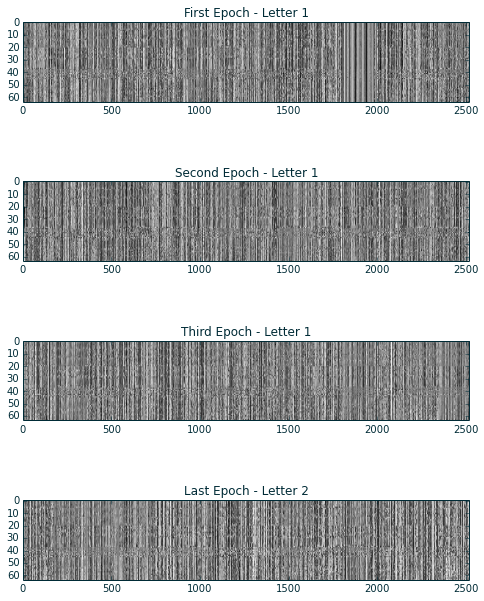

In [18]:
plt.gray()
firstEpoch = x_trainTemp[:, 0:2520]
secondEpoch = x_trainTemp[:, 2520:5040]
thirdEpoch = x_trainTemp[:, 5040:7560]
lastEpoch = x_trainTemp[:, 211680:]

import matplotlib.gridspec as gridspec

plt.figure(figsize=(8,10))
gs3 = gridspec.GridSpec(4, 1)
plt.subplots_adjust(hspace=1)

plt.subplot(gs3[0, 0])
np.savetxt('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/temp.txt', firstEpoch, fmt='%1.5f')

plt.title("First Epoch - Letter {}".format(separateLabels[0]))
plt.imshow(firstEpoch, aspect='auto') #If you don't need an equal aspect you can set aspect to auto
plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images.png')

plt.subplot(gs3[1, 0])
plt.title("Second Epoch - Letter {}".format(separateLabels[1]))
plt.imshow(secondEpoch, aspect='auto') #If you don't need an equal aspect you can set aspect to auto
plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images.png')

plt.subplot(gs3[2, 0])
plt.title("Third Epoch - Letter {}".format(separateLabels[2]))
plt.imshow(thirdEpoch, aspect='auto') #If you don't need an equal aspect you can set aspect to auto
plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images.png')

plt.subplot(gs3[3, 0])
plt.title("Last Epoch - Letter {}".format(separateLabels[84]))
plt.imshow(lastEpoch, aspect='auto') #If you don't need an equal aspect you can set aspect to auto
plt.savefig('/Users/shreya/Documents/workspace/BCI3Data2/EEGDataCode/Images.png')


#### Importing libraries necessary for building the convolutional neural network

In [19]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

In [20]:
batch_size = 4 # Size of the subset of examples to use when performing gradient descent during training
num_classes = 6 # each class corresponds to one of the rows of the matrix
epochs = 12
x_train = x_train.reshape(85, 64, 2520, 1)
x_test = x_test.reshape(100, 64, 2520, 1)
input_shape = (64, 2520, 1)

In [21]:
model = Sequential()

First, a convolutional layer with **32** output channels, a kernel size of **2 x 40**, stride size of **1 x 4**, and a subsequent **ReLU** activation layer.

In [22]:
model.add(Conv2D(32, kernel_size=(2,40), strides=(1, 4), activation='relu', input_shape=input_shape))

Second, a pooling layer with a pooling size of **2 x 2**.

In [23]:
model.add(MaxPooling2D(pool_size=(2,2)))

Third, another convolutional layer with **64** output channels, a kernel size of **1 x 10**, a  stride size of **1 x 2**, and a subsequent **ReLU** activation layer.

In [24]:
model.add(Conv2D(64, (1,10), strides=(1,2), activation='relu'))

Fourth, another pooling layer with a pooling size of **2 x 2**.

In [25]:
model.add(MaxPooling2D(pool_size=(2,2)))

After flattening the input from the previous layer to a vector, feed it to a **hidden layer** of 1000 nodes, followed by a **ReLU** activation layer.

In [26]:
model.add(Flatten())
model.add(Dense(1000, activation='relu'))

Finally, a **softmax** activation  is applied to the output layer with 6 nodes for the 6 classes to determine the class with the highest probability of being the correct answer.

In [27]:
model.add(Dense(num_classes, activation='softmax'))

In [28]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])

In [29]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 85 samples, validate on 100 samples
Epoch 1/12
85/85 [==============================] - 49s 573ms/step - loss: 1.9289 - acc: 0.2824 - val_loss: 1.9545 - val_acc: 0.2400
Epoch 2/12
85/85 [==============================] - 31s 360ms/step - loss: 1.5684 - acc: 0.3294 - val_loss: 1.8754 - val_acc: 0.2400
Epoch 3/12
85/85 [==============================] - 27s 322ms/step - loss: 1.3960 - acc: 0.4941 - val_loss: 1.9740 - val_acc: 0.1500
Epoch 4/12
85/85 [==============================] - 31s 369ms/step - loss: 1.1781 - acc: 0.6588 - val_loss: 1.8170 - val_acc: 0.1700
Epoch 5/12
85/85 [==============================] - 27s 322ms/step - loss: 0.8796 - acc: 0.8824 - val_loss: 2.4441 - val_acc: 0.1500
Epoch 6/12
85/85 [==============================] - 29s 343ms/step - loss: 0.5286 - acc: 0.9412 - val_loss: 2.6230 - val_acc: 0.1500
Epoch 7/12
85/85 [==============================] - 30s 352ms/step - loss: 0.3048 - acc: 0.9647 - val_loss: 2.3084 - val_acc: 0.1500
Epoch 8/12
85/85 [======

In [30]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.0302034282684325
Test accuracy: 0.26
